In [ ]:
import pandas as pd
import numpy as np

# LSTM Model for timeseries forcast
The scope of this project is to develop a special kind of recurrent neuronal network, namly long short term memory (LSTM). The big adavantage of this special kind is that it solves the vanishing gradient problem and in comparison to conventional feed forward networks it has not only long term memory, but it can indivate features from the data an save and delete this kind of short term memory during learning and the predictions. It is a multivariate time series forcast, as input features are used per timestep to predict the target label.

- we start of by importing the dataset
- it is the inflow of water based on some meteo data, this is the quanity we want to predict in the next timestep


In [67]:
data = pd.read_csv("Inflow_Model_Example_Somma_last/Inflow_Model_Example/DLA_HAU_RE4_Inflow_Forecast_Model_Data_2021_02_03_11_22.csv", decimal=',', delimiter=';')
data=data.fillna(data.mean())
print(data.head(10))

          timestamp  inflow_m3_per_sec  evaporation_mmt  fresh_snow_mmt  \
0  09/02/2016 00:00           0.710961         0.006250        0.241667   
1  10/02/2016 00:00           0.430148        -0.006250        0.170833   
2  11/02/2016 00:00           0.304613        -0.018333        0.000000   
3  12/02/2016 00:00           0.000000        -0.025000        0.000000   
4  13/02/2016 00:00           0.022164        -0.017500        0.000000   
5  14/02/2016 00:00           0.000000        -0.015000        0.000000   
6  15/02/2016 00:00           0.000000        -0.015000        0.000000   
7  16/02/2016 00:00           0.000000        -0.010000        0.025000   
8  17/02/2016 00:00           0.000000        -0.028750        0.100000   
9  18/02/2016 00:00           0.000000        -0.012917        0.108333   

   precipitation_mmt  precipitation_type_mmt  radiation_mmt  snow_depth_mmt  \
0           0.315417                    0.25      24.162500       23.579167   
1           0.12

/var/folders/vw/4d6l2vcs2_d7xcp6s_tqf9mw0000gn/T/ipykernel_46524/1617389563.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data=data.fillna(data.mean())


- we split the data into training and test data ((0/20))
- and we apply scaling to the training data by the fit_transform() method
- the test data is only transormed based on the scaling from the trainingsdata, that's why we only use the transform() method

In [110]:
n_split = int(0.8*len(data))
print(n_split)
training_set = np.array(data.iloc[0: n_split-1, 1:15])
test_set = np.array(data.iloc[n_split:, 1:15])
print(training_set.shape)
print(np.append(training_set, test_set, axis=0).shape)

1456
(1455, 14)
(1820, 14)


In [111]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

test_set_scaled = sc.transform(np.append(training_set, test_set, axis=0))
# the test set is only transformed according to the scaling of the trainings set


- n_timepsteps gives the number of past timesteps is used for the forcast
- n_split is the index where the split bewteen test and traing data lies, where i=n_split is the first element of the test data
- the returned data respect the required tensor dimensions for the rnn implemented in keras/tensorflow 
- Input shape for the LSTM is ( # samples, # timesteps, # features) for the input vector, the label is (# samples,)

In [130]:

n_split = int(0.8*len(training_set_scaled))
n_timesteps = 10
n_split = int(0.8*len(training_set_scaled))
X_train = np.expand_dims(training_set_scaled[0:n_timesteps, 0:], axis =0)
y_train = np.array(training_set_scaled[n_timesteps,0:1])
X_test = np.expand_dims(test_set_scaled[n_split-n_timesteps:n_split, 0:], axis =0)
y_test = test_set_scaled[n_split,0:1]

for index in range(n_split-n_timesteps+1, len(test_set_scaled)-n_timesteps):
    X_test = np.append(X_test, np.expand_dims(test_set_scaled[index:n_timesteps+index, 0:], axis =0),  axis=0)
    y_test = np.append(y_test, test_set_scaled[index+n_timesteps, 0:1])


for index in range(1, n_split):
    X_train = np.append(X_train, np.expand_dims(training_set_scaled[index:n_timesteps+index, 0:], axis =0),  axis=0)
    y_train = np.append(y_train, training_set_scaled[index+n_timesteps, 0:1])



print(X_train.shape[1], y_train.shape)
#print(y_train.shape, y_test.shape)


10 (1164,)


- now we define the network: a LSTM network with four hiddenlayers of dimension 50 and a dropout regularization to prevent overfitting (20% of the neurons are randomly removed at every call)

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [131]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2)) # to avoid overfitting, just a regularization in the weight update 
#20% are randomly droped in every cycle
# return sequence true if a stacked LSTM 

Adding a second layer

In [132]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

Adding a third layer

In [133]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

Adding a fourth layer

In [134]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

Adding the Output layer, it is a fully-connected dense layer without activation function as we want to do a regression of the label column

In [135]:
regressor.add(Dense(units = 1))

# Buliding and Training the model

In [136]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [139]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 2/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 3/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 4/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 5/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 6/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 7/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 8/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 9/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 10/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 11/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 12/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 13/100
37/37 [=================

In [154]:
y_pred = regressor.predict(X_test)
print(y_pred.shape)

21/21 [==============================] - 0s 3ms/step
(656, 1)


In [156]:
y_pred =np.reshape(y_pred, (y_pred.shape[0])) #sc.inverse_transform(y_pred)
print(y_pred, y_test)

[ 2.75909007e-02  2.79534422e-02  2.70020515e-02  2.57880278e-02
  2.41365284e-02  2.27322578e-02  2.09129676e-02  3.67770717e-02
  5.33835739e-02  6.39242753e-02  1.64723694e-01  1.24432027e-01
  6.92820176e-02  4.93321754e-02  3.99041064e-02  3.80569510e-02
  4.41155098e-02  3.79283912e-02  3.95652689e-02  3.67652811e-02
  4.10773866e-02  3.71662267e-02  5.88047802e-02  1.06246725e-01
  7.76897818e-02  5.09259738e-02  3.82717289e-02  3.32211927e-02
  3.25597934e-02  3.10232639e-02  3.24116610e-02  4.70152237e-02
  4.64470722e-02  3.89603488e-02  5.41935191e-02  6.28119931e-02
  2.17624485e-01  1.38235360e-01  7.19480664e-02  4.79085445e-02
  3.97317596e-02  3.84706035e-02  4.66496050e-02  9.28749144e-02
  7.06810132e-02  1.13104567e-01  1.13090873e-01  1.14247195e-01
  8.21107551e-02  9.39834788e-02  1.12085320e-01  8.02707076e-02
  1.39485881e-01  1.39607593e-01  8.88409689e-02  7.97805861e-02
  1.01049773e-01  1.16451710e-01  1.25106007e-01  9.42752063e-02
  7.99301118e-02  8.80671

In [157]:
import matplotlib.pyplot as plt

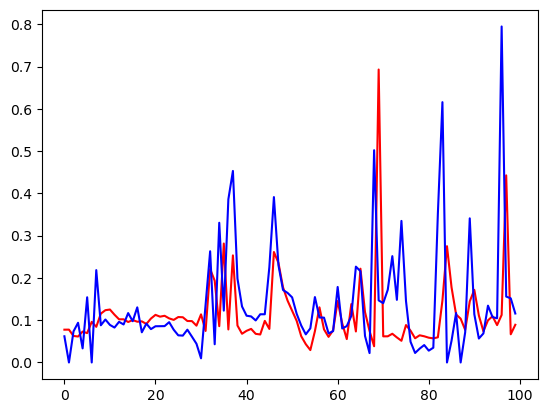

In [167]:
plt.plot(y_pred[200:300], color="red", label= "predicted values")
plt.plot(y_test[200:300], color="blue", label = "actual values")
plt.show()

- considering the big randomness in dealing with meteo data the model does an eccelent job by prediciting the trends in the timeseries. Maybe you can do even better?
- Try different number of layers, more neuorns or more past time steps?